<a href="https://colab.research.google.com/github/amyzhang-USC/Investment-Analysis/blob/main/program%E4%BB%A3%E7%A0%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Necessary Packages



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install pandas_bokeh

In [4]:
import pandas_bokeh

##Exploratory Data Analysis

In [5]:
morningstar_funds = pd.read_csv("/content/drive/Shareddrives/RMDS/funds.csv")
morningstar_funds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6003 entries, 0 to 6002
Data columns (total 29 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Name                                                6003 non-null   object 
 1   Ticker                                              6002 non-null   object 
 2   Morningstar Sustainability Rating                   5993 non-null   float64
 3   Yield (%)                                           5910 non-null   float64
 4   Morningstar Category                                6001 non-null   object 
 5   Portfolio Sustainability Score                      5993 non-null   float64
 6   Portfolio Environmental Score                       5993 non-null   float64
 7   Portfolio Social Score                              5993 non-null   float64
 8   Portfolio Governance Score                          5991 non-null   float64
 9

In [6]:
morningstar_funds.describe()

,Morningstar Sustainability Rating,Yield (%),Portfolio Sustainability Score,Portfolio Environmental Score,Portfolio Social Score,Portfolio Governance Score,Animal Testing,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,YTD Return (%),1 Year Annualized (%),3 Years Annualized (%),5 Years Annualized (%),10 Years Annualized (%)
count,5993.000000,5910.000000,5993.000000,5993.000000,5993.000000,5991.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,6003.000000,5965.000000
mean,3.506257,0.958667,22.367559,3.731320,8.554747,6.489062,0.014160,0.722409,5.893253,0.612870,1.059207,0.463227,12.989029,26.164989,15.713695,13.013440,10.943881
std,0.722056,1.266840,2.868454,1.522058,2.264916,1.584564,0.118158,1.436546,9.783290,0.959304,2.722055,0.917594,10.030741,16.797509,7.289129,6.380436,4.962711
min,1.000000,0.000000,10.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.930000,-20.120000,-11.170000,-9.340000,-5.860000
25%,3.000000,0.030000,20.770000,2.980000,8.160000,6.300000,0.000000,0.000000,1.155000,0.000000,0.000000,0.000000,6.330000,13.820000,11.020000,9.025000,7.570000
50%,3.000000,0.670000,22.270000,3.750000,9.140000,7.010000,0.000000,0.080000,4.820000,0.170000,0.450000,0.000000,13.430000,26.840000,15.210000,12.710000,11.350000
75%,4.000000,1.380000,23.530000,4.210000,9.850000,7.330000,0.000000,0.900000,7.010000,0.870000,1.305000,0.620000,20.335000,38.195000,20.020000,16.865000,14.620000
max,5.000000,34.080000,35.200000,14.040000,14.530000,11.200000,1.000000,19.970000,100.690000,7.910000,63.910000,12.250000,60.970000,113.530000,49.750000,36.510000,25.530000


##Portfolio Environment Score Regression

In [7]:
morningstar_funds = pd.read_csv("/content/drive/Shareddrives/RMDS/funds.csv")
morningstar_funds = morningstar_funds[["Ticker","Name","Portfolio Environmental Score","% Alcohol","% Fossil Fuels","% Small Arms","% Thermal Coal","% Tobacco","Sustainable Investment by Prospectus","Sustainable Investment - ESG Fund","Sustainable Investment - Impact Fund","Sustainable Investment - Environmental Sector Fund"]]
morningstar_funds

,Ticker,Name,Portfolio Environmental Score,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,Sustainable Investment by Prospectus,Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund
0,AWPCX,AB Sustainable Intl Thematic C,4.21,0.00,3.73,0.00,1.90,0.0,Yes,Yes,Yes,No
1,STHAX,AB Sustainable Thematic Credit A,3.39,0.00,8.24,0.00,2.25,0.0,Yes,Yes,Yes,No
2,STHYX,AB Sustainable Thematic Credit Advisor,3.39,0.00,8.24,0.00,2.25,0.0,Yes,Yes,Yes,No
3,BJBIX,Aberdeen International Sust Ldrs A,3.31,0.00,2.33,0.00,2.34,0.0,Yes,Yes,No,No
4,JIEIX,Aberdeen International Sust Ldrs I,3.31,0.00,2.33,0.00,2.34,0.0,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
5998,EKSAX,Wells Fargo Diversified Income Bldr A,4.74,0.22,6.67,1.73,0.39,0.1,No,No,No,No
5999,EKSDX,Wells Fargo Diversified Income Bldr Adm,4.74,0.22,6.67,1.73,0.39,0.1,No,No,No,No
6000,EKSCX,Wells Fargo Diversified Income Bldr C,4.74,0.22,6.67,1.73,0.39,0.1,No,No,No,No
6001,EKSYX,Wells Fargo Diversified Income Bldr Inst,4.74,0.22,6.67,1.73,0.39,0.1,No,No,No,No


In [8]:
bloomberg_funds = pd.read_excel("/content/drive/Shareddrives/RMDS/bloomberg_funds.xlsx")
bloomberg_funds = bloomberg_funds[["Ticker","Key","Climate/Clean Tech","Pollution/Toxics","Environment/Other"]]
bloomberg_funds

,Ticker,Key,Climate/Clean Tech,Pollution/Toxics,Environment/Other
0,SSIAX,1919 Socially Responsive Balanced Fund - A,C,R,C
1,SESLX,1919 Socially Responsive Balanced Fund - C,C,R,C
2,LMRNX,1919 Socially Responsive Balanced Fund - I,C,R,C
3,ACASX,Access Capital Community Investment Fund A,-- *,X,--
4,ACCSX,Access Capital Community Investment Fund I,-- *,--,--
...,...,...,...,...,...
175,WSEFX,Walden Equity Fund,C,C,C
176,WAMFX,Walden Midcap Fund,C,C,C
177,WASOX,Walden Small Cap Innovations Fund,P,P,P
178,WASMX,Walden SMID Cap Innovations Fund,P,P,P


In [9]:
 # Combine two datasets together
environment_data = morningstar_funds.merge(bloomberg_funds, left_on='Ticker', right_on='Ticker')
environment_data = environment_data.drop(columns=['Key'])
environment_data

,Ticker,Name,Portfolio Environmental Score,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,Sustainable Investment by Prospectus,Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund,Climate/Clean Tech,Pollution/Toxics,Environment/Other
0,REDWX,Aspiration Redwood,2.75,0.00,0.00,0.00,0.00,0.0,Yes,Yes,No,No,P,P,P
1,BVSIX,Baywood Socially Responsible Instl,3.87,0.00,12.80,0.00,0.00,0.0,Yes,Yes,No,No,C,C,C
2,CSIBX,Calvert Bond A,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C
3,CSBCX,Calvert Bond C,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C
4,CBDIX,Calvert Bond I,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,DSEFX,Domini Impact Equity Investor,2.77,0.00,0.42,0.00,0.11,0.0,Yes,Yes,Yes,No,C,C,C
166,DSFRX,Domini Impact Equity Y,2.77,0.00,0.42,0.00,0.11,0.0,Yes,Yes,Yes,No,C,C,C
167,GCBLX,Green Century Balanced,2.57,0.00,0.00,0.00,0.00,0.0,Yes,Yes,Yes,No,C *,R,C
168,GCINX,Green Century MSCI Intl Indx Indvl Inv,3.38,0.25,0.41,0.00,0.00,0.0,Yes,Yes,Yes,No,C *,R,C


In [10]:
# Check whether new data has any null values
print(environment_data.isnull().any())

Ticker                                                False
Name                                                  False
Portfolio Environmental Score                          True
% Alcohol                                             False
% Fossil Fuels                                        False
% Small Arms                                          False
% Thermal Coal                                        False
% Tobacco                                             False
Sustainable Investment by Prospectus                  False
Sustainable Investment - ESG Fund                     False
Sustainable Investment - Impact Fund                  False
Sustainable Investment - Environmental Sector Fund    False
Climate/Clean Tech                                    False
Pollution/Toxics                                      False
Environment/Other                                     False
dtype: bool


In [11]:
# Drop Null Values
environment_data = environment_data.dropna(subset=['Portfolio Environmental Score'])
environment_data

,Ticker,Name,Portfolio Environmental Score,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,Sustainable Investment by Prospectus,Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund,Climate/Clean Tech,Pollution/Toxics,Environment/Other
0,REDWX,Aspiration Redwood,2.75,0.00,0.00,0.00,0.00,0.0,Yes,Yes,No,No,P,P,P
1,BVSIX,Baywood Socially Responsible Instl,3.87,0.00,12.80,0.00,0.00,0.0,Yes,Yes,No,No,C,C,C
2,CSIBX,Calvert Bond A,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C
3,CSBCX,Calvert Bond C,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C
4,CBDIX,Calvert Bond I,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,DSEFX,Domini Impact Equity Investor,2.77,0.00,0.42,0.00,0.11,0.0,Yes,Yes,Yes,No,C,C,C
166,DSFRX,Domini Impact Equity Y,2.77,0.00,0.42,0.00,0.11,0.0,Yes,Yes,Yes,No,C,C,C
167,GCBLX,Green Century Balanced,2.57,0.00,0.00,0.00,0.00,0.0,Yes,Yes,Yes,No,C *,R,C
168,GCINX,Green Century MSCI Intl Indx Indvl Inv,3.38,0.25,0.41,0.00,0.00,0.0,Yes,Yes,Yes,No,C *,R,C


In [12]:
# Create a column called "Fossil Fuels Restrictions" if there exits "*" in "Climate/Clean Tech" variable, 
# then remove "*" in order to create dummy variables more easily
# replace "--" (missing values) to C (Combination of Positive and Restricted/exclusionary strategies) since C is the most existing category
environment_data["Fossil Fuels Restrictions"] = np.where((environment_data["Climate/Clean Tech"] == "C *") | (environment_data["Climate/Clean Tech"] == "R *") | (environment_data["Climate/Clean Tech"] == "P *") | (environment_data["Climate/Clean Tech"] == "-- *"),1,0)
environment_data["Climate/Clean Tech"] = np.where((environment_data["Climate/Clean Tech"] == "C *"),"C",environment_data["Climate/Clean Tech"])
environment_data["Climate/Clean Tech"] = np.where((environment_data["Climate/Clean Tech"] == "P *"),"P",environment_data["Climate/Clean Tech"])
environment_data["Climate/Clean Tech"] = np.where((environment_data["Climate/Clean Tech"] == "R *"),"R",environment_data["Climate/Clean Tech"])
environment_data["Climate/Clean Tech"] = np.where((environment_data["Climate/Clean Tech"] == "-- *"),"C",environment_data["Climate/Clean Tech"])
environment_data["Pollution/Toxics"] = np.where((environment_data["Pollution/Toxics"] == "--"),"C",environment_data["Pollution/Toxics"])
environment_data["Environment/Other"] = np.where((environment_data["Environment/Other"] == "--"),"C",environment_data["Environment/Other"])
environment_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Ticker,Name,Portfolio Environmental Score,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,Sustainable Investment by Prospectus,Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund,Climate/Clean Tech,Pollution/Toxics,Environment/Other,Fossil Fuels Restrictions
0,REDWX,Aspiration Redwood,2.75,0.00,0.00,0.00,0.00,0.0,Yes,Yes,No,No,P,P,P,0
1,BVSIX,Baywood Socially Responsible Instl,3.87,0.00,12.80,0.00,0.00,0.0,Yes,Yes,No,No,C,C,C,0
2,CSIBX,Calvert Bond A,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C,0
3,CSBCX,Calvert Bond C,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C,0
4,CBDIX,Calvert Bond I,2.73,0.00,2.74,0.32,1.32,0.0,Yes,Yes,Yes,No,C,C,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,DSEFX,Domini Impact Equity Investor,2.77,0.00,0.42,0.00,0.11,0.0,Yes,Yes,Yes,No,C,C,C,0
166,DSFRX,Domini Impact Equity Y,2.77,0.00,0.42,0.00,0.11,0.0,Yes,Yes,Yes,No,C,C,C,0
167,GCBLX,Green Century Balanced,2.57,0.00,0.00,0.00,0.00,0.0,Yes,Yes,Yes,No,C,R,C,1
168,GCINX,Green Century MSCI Intl Indx Indvl Inv,3.38,0.25,0.41,0.00,0.00,0.0,Yes,Yes,Yes,No,C,R,C,1


In [13]:
# Use dummy variables to transform categorical variables
environment_data = pd.get_dummies(environment_data,columns=['Climate/Clean Tech','Pollution/Toxics','Environment/Other','Sustainable Investment by Prospectus','Sustainable Investment - ESG Fund','Sustainable Investment - Impact Fund','Sustainable Investment - Environmental Sector Fund'],drop_first=True)
environment_data


,Ticker,Name,Portfolio Environmental Score,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,Fossil Fuels Restrictions,Climate/Clean Tech_C,Climate/Clean Tech_P,Pollution/Toxics_P,Pollution/Toxics_R,Pollution/Toxics_X,Environment/Other_P,Sustainable Investment - ESG Fund_Yes,Sustainable Investment - Impact Fund_Yes,Sustainable Investment - Environmental Sector Fund_Yes
0,REDWX,Aspiration Redwood,2.75,0.00,0.00,0.00,0.00,0.0,0,0,1,1,0,0,1,1,0,0
1,BVSIX,Baywood Socially Responsible Instl,3.87,0.00,12.80,0.00,0.00,0.0,0,1,0,0,0,0,0,1,0,0
2,CSIBX,Calvert Bond A,2.73,0.00,2.74,0.32,1.32,0.0,0,1,0,0,0,0,0,1,1,0
3,CSBCX,Calvert Bond C,2.73,0.00,2.74,0.32,1.32,0.0,0,1,0,0,0,0,0,1,1,0
4,CBDIX,Calvert Bond I,2.73,0.00,2.74,0.32,1.32,0.0,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,DSEFX,Domini Impact Equity Investor,2.77,0.00,0.42,0.00,0.11,0.0,0,1,0,0,0,0,0,1,1,0
166,DSFRX,Domini Impact Equity Y,2.77,0.00,0.42,0.00,0.11,0.0,0,1,0,0,0,0,0,1,1,0
167,GCBLX,Green Century Balanced,2.57,0.00,0.00,0.00,0.00,0.0,1,1,0,0,1,0,0,1,1,0
168,GCINX,Green Century MSCI Intl Indx Indvl Inv,3.38,0.25,0.41,0.00,0.00,0.0,1,1,0,0,1,0,0,1,1,0


In [14]:
# Simple description on data
environment_data.describe()

,Portfolio Environmental Score,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,Fossil Fuels Restrictions,Climate/Clean Tech_C,Climate/Clean Tech_P,Pollution/Toxics_P,Pollution/Toxics_R,Pollution/Toxics_X,Environment/Other_P,Sustainable Investment - ESG Fund_Yes,Sustainable Investment - Impact Fund_Yes,Sustainable Investment - Environmental Sector Fund_Yes
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,3.317278,0.127515,3.553491,0.094438,1.015444,0.019763,0.147929,0.692308,0.147929,0.118343,0.071006,0.011834,0.195266,0.976331,0.769231,0.065089
std,1.013648,0.405230,5.044722,0.337037,1.488743,0.093203,0.356085,0.462910,0.356085,0.323974,0.257598,0.108461,0.397584,0.152466,0.422577,0.247415
min,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.760000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,3.400000,0.000000,2.210000,0.000000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,3.760000,0.000000,4.720000,0.000000,1.370000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,5.880000,2.430000,36.500000,2.370000,7.480000,0.820000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Linear Rgression with dependent variable Portfolio Environmental Score, independent variables % Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,Climate/Clean Tech,Pollution/Toxics,Environment/Other
y = environment_data["Portfolio Environmental Score"]
X = environment_data.iloc[:,3:]
regressor = LinearRegression()
#X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                                      OLS Regression Results                                      
Dep. Variable:     Portfolio Environmental Score   R-squared (uncentered):                   0.953
Model:                                       OLS   Adj. R-squared (uncentered):              0.949
Method:                            Least Squares   F-statistic:                              209.4
Date:                           Tue, 01 Feb 2022   Prob (F-statistic):                    3.55e-94
Time:                                   00:26:05   Log-Likelihood:                         -191.10
No. Observations:                            169   AIC:                                      412.2
Df Residuals:                                154   BIC:                                      459.2
Df Model:                                     15                                                  
Covariance Type:                       nonrobust                                                  
          

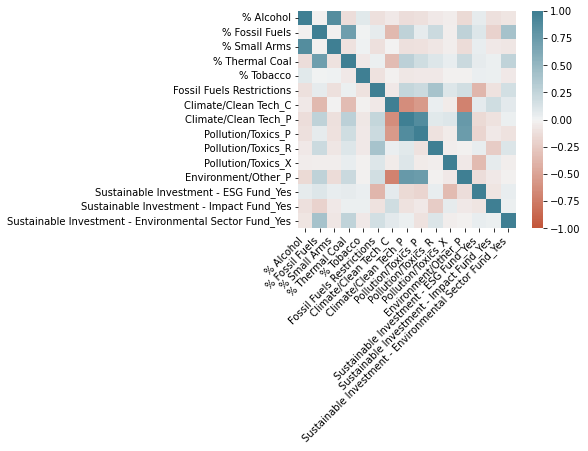

In [16]:
# Find correlations between variables that determine Portfolio Environmental Score
corrMatrix = X.corr()
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [17]:
# Improve Regression based on correlation
# Remove highly correlated variables (with correlation index > 0.8)
# environment_data_new = environment_data[["Portfolio Environmental Score","% Fossil Fuels","% Small Arms","% Thermal Coal","% Tobacco","Fossil Fuels Restrictions","Climate/Clean Tech_C","Pollution/Toxics_R","Pollution/Toxics_X","Environment/Other_P","Sustainable Investment - ESG Fund_Yes","Sustainable Investment - Impact Fund_Yes","Sustainable Investment - Environmental Sector Fund_Yes"]]
environment_data_new = environment_data[["Portfolio Environmental Score","% Thermal Coal","% Small Arms","% Tobacco","Fossil Fuels Restrictions","Pollution/Toxics_R","Pollution/Toxics_X","Climate/Clean Tech_C","Sustainable Investment - ESG Fund_Yes","Sustainable Investment - Impact Fund_Yes","Sustainable Investment - Environmental Sector Fund_Yes"]]
y = environment_data_new["Portfolio Environmental Score"]
X = environment_data_new.iloc[:,1:]
regressor = LinearRegression()
#X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                                      OLS Regression Results                                      
Dep. Variable:     Portfolio Environmental Score   R-squared (uncentered):                   0.950
Model:                                       OLS   Adj. R-squared (uncentered):              0.946
Method:                            Least Squares   F-statistic:                              299.7
Date:                           Tue, 01 Feb 2022   Prob (F-statistic):                    1.05e-97
Time:                                   00:26:06   Log-Likelihood:                         -197.47
No. Observations:                            169   AIC:                                      414.9
Df Residuals:                                159   BIC:                                      446.2
Df Model:                                     10                                                  
Covariance Type:                       nonrobust                                                  
          

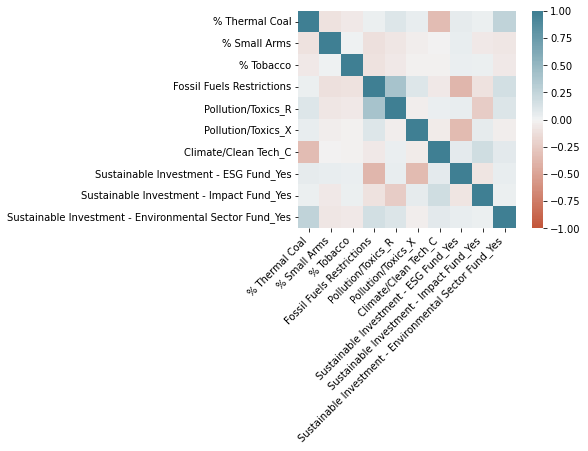

In [18]:
# Find correlations between variables that determine Portfolio Environmental Score
corrMatrix = X.corr()
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

##Portfolio Social Score Regression

In [19]:
morningstar_df = pd.read_csv("/content/drive/Shareddrives/RMDS/funds.csv")
pd.set_option('display.max_columns', None)

# drop unnecessary columns
morningstar = morningstar_df[['Name','Ticker','Yield (%)','Morningstar Category','Portfolio Social Score']]
morningstar.drop(columns=['Yield (%)'],inplace=True)
morningstar

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Name,Ticker,Morningstar Category,Portfolio Social Score
0,AB Sustainable Intl Thematic C,AWPCX,Global Equity Large Cap,8.13
1,AB Sustainable Thematic Credit A,STHAX,US Fixed Income,8.11
2,AB Sustainable Thematic Credit Advisor,STHYX,US Fixed Income,8.11
3,Aberdeen International Sust Ldrs A,BJBIX,Global Equity Large Cap,8.61
4,Aberdeen International Sust Ldrs I,JIEIX,Global Equity Large Cap,8.61
...,...,...,...,...
5998,Wells Fargo Diversified Income Bldr A,EKSAX,Cautious Allocation,8.53
5999,Wells Fargo Diversified Income Bldr Adm,EKSDX,Cautious Allocation,8.53
6000,Wells Fargo Diversified Income Bldr C,EKSCX,Cautious Allocation,8.53
6001,Wells Fargo Diversified Income Bldr Inst,EKSYX,Cautious Allocation,8.53


In [20]:
columns = ['Ticker','10yr_yield','fund_name','social_comm_develop','social_diversity','social_human_rights','social_labor','social_conflict', 'ESG', 'Impact']
bloomberg_df = pd.read_excel("/content/drive/Shareddrives/RMDS/socialdata.xlsx",names=columns)
bloomberg_df.drop(columns=['10yr_yield'],inplace=True)
bloomberg_df

,Ticker,fund_name,social_comm_develop,social_diversity,social_human_rights,social_labor,social_conflict,ESG,Impact
0,SSIAX,1919 Socially Responsive Balanced Fund - A,C,C,C,C,R,Yes,No
1,SESLX,1919 Socially Responsive Balanced Fund - C,C,C,C,C,R,Yes,No
2,LMRNX,1919 Socially Responsive Balanced Fund - I,C,C,C,C,R,Yes,No
3,ACASX,Access Capital Community Investment Fund A,P,--,--,--,X,No,Yes
4,ACCSX,Access Capital Community Investment Fund I,P,--,--,--,X,No,Yes
...,...,...,...,...,...,...,...,...,...
175,WSEFX,Walden Equity Fund,C,C,R,C,--,Yes,No
176,WAMFX,Walden Midcap Fund,C,C,R,C,--,Yes,No
177,WASOX,Walden Small Cap Innovations Fund,P,P,R,P,--,--,--
178,WASMX,Walden SMID Cap Innovations Fund,P,P,R,P,--,Yes,No


In [21]:
# replace -- with null values
bloomberg_df.replace('--',np.nan,inplace=True)
# change datatypes
# bloomberg_df['10yr_yield'] = pd.to_numeric(bloomberg_df['10yr_yield'])
bloomberg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Ticker               180 non-null    object
 1   fund_name            180 non-null    object
 2   social_comm_develop  158 non-null    object
 3   social_diversity     164 non-null    object
 4   social_human_rights  161 non-null    object
 5   social_labor         161 non-null    object
 6   social_conflict      77 non-null     object
 7   ESG                  170 non-null    object
 8   Impact               170 non-null    object
dtypes: object(9)
memory usage: 12.8+ KB


In [22]:
# join two dataframes
social_data = pd.merge(left=morningstar,right=bloomberg_df,left_on="Ticker",right_on='Ticker')
social_data.shape
social_data.drop(columns=['fund_name'],inplace=True)

In [23]:
# check null values
social_data.isnull().any()

Name                      False
Ticker                    False
Morningstar Category       True
Portfolio Social Score     True
social_comm_develop        True
social_diversity           True
social_human_rights        True
social_labor               True
social_conflict            True
ESG                       False
Impact                    False
dtype: bool

In [24]:
# drop rows with missing portfolio social score
social_data = social_data.dropna(subset=['Portfolio Social Score'])
social_data.shape

(169, 11)

In [25]:
# check unique values of social variables
# fill in na values
columns = social_data.columns
for i in range(4,10):
  print("Unique values in", columns[i], social_data[columns[i]].unique())
  social_data = social_data.fillna(social_data['social_comm_develop'].value_counts().index[0])
# check null value again
social_data.info()

Unique values in social_comm_develop ['P' nan 'C']
Unique values in social_diversity ['P' 'C']
Unique values in social_human_rights ['P' 'C' 'R']
Unique values in social_labor ['P' 'C' 'R']
Unique values in social_conflict ['X' 'C' 'R' 'P']
Unique values in ESG ['Yes' 'No']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 169
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    169 non-null    object 
 1   Ticker                  169 non-null    object 
 2   Morningstar Category    169 non-null    object 
 3   Portfolio Social Score  169 non-null    float64
 4   social_comm_develop     169 non-null    object 
 5   social_diversity        169 non-null    object 
 6   social_human_rights     169 non-null    object 
 7   social_labor            169 non-null    object 
 8   social_conflict         169 non-null    object 
 9   ESG                     169 non-

In [26]:
# create dummy variables
social_data = pd.get_dummies(social_data,columns=['social_comm_develop','social_diversity','social_human_rights','social_labor','social_conflict','ESG','Impact'],drop_first=True)
social_data

,Name,Ticker,Morningstar Category,Portfolio Social Score,social_comm_develop_P,social_diversity_P,social_human_rights_P,social_human_rights_R,social_labor_P,social_labor_R,social_conflict_P,social_conflict_R,social_conflict_X,ESG_Yes,Impact_Yes
0,Aspiration Redwood,REDWX,US Equity Large Cap Blend,8.94,1,1,1,0,1,0,0,0,1,1,0
1,Baywood Socially Responsible Instl,BVSIX,US Equity Large Cap Value,8.32,0,0,0,0,0,0,0,0,0,1,0
2,Calvert Bond A,CSIBX,US Fixed Income,9.22,1,0,0,0,0,0,0,0,1,1,1
3,Calvert Bond C,CSBCX,US Fixed Income,9.22,1,0,0,0,0,0,0,0,1,1,1
4,Calvert Bond I,CBDIX,US Fixed Income,9.22,1,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Domini Impact Equity Investor,DSEFX,US Equity Large Cap Blend,9.39,0,0,0,0,0,0,0,1,0,1,1
166,Domini Impact Equity Y,DSFRX,US Equity Large Cap Blend,9.39,0,0,0,0,0,0,0,1,0,1,1
167,Green Century Balanced,GCBLX,Moderate Allocation,8.24,1,0,0,0,1,0,0,0,0,1,1
168,Green Century MSCI Intl Indx Indvl Inv,GCINX,Global Equity Large Cap,7.99,0,0,0,0,0,0,0,0,0,1,1


In [27]:
y = social_data['Portfolio Social Score']
X = social_data.iloc[:,4:15]

In [28]:
regressor = LinearRegression()
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Portfolio Social Score   R-squared (uncentered):                   0.932
Model:                                OLS   Adj. R-squared (uncentered):              0.927
Method:                     Least Squares   F-statistic:                              195.7
Date:                    Tue, 01 Feb 2022   Prob (F-statistic):                    5.12e-86
Time:                            00:26:08   Log-Likelihood:                         -374.50
No. Observations:                     169   AIC:                                      771.0
Df Residuals:                         158   BIC:                                      805.4
Df Model:                              11                                                  
Covariance Type:                nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025   

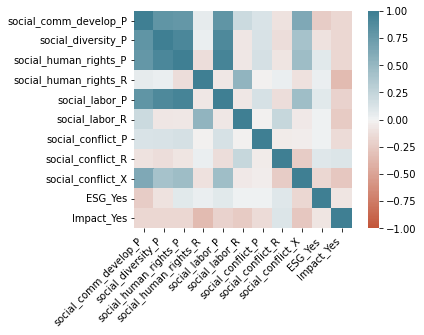

In [29]:
# Correlation Matrix among variables
corrMatrix = X.corr()
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [30]:
# drop one of the variables with high correlation
y = social_data['Portfolio Social Score']
X = social_data.drop(columns=['Name','Ticker','Morningstar Category','Portfolio Social Score','social_comm_develop_P','social_human_rights_P','social_labor_P'])
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Portfolio Social Score   R-squared (uncentered):                   0.913
Model:                                OLS   Adj. R-squared (uncentered):              0.909
Method:                     Least Squares   F-statistic:                              212.1
Date:                    Tue, 01 Feb 2022   Prob (F-statistic):                    2.27e-81
Time:                            00:26:09   Log-Likelihood:                         -394.54
No. Observations:                     169   AIC:                                      805.1
Df Residuals:                         161   BIC:                                      830.1
Df Model:                               8                                                  
Covariance Type:                nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025   

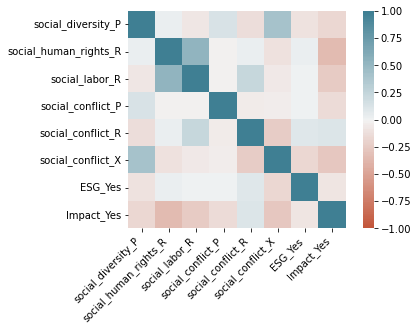

In [31]:
corrMatrix = X.corr()
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

##Model Development -- Random Forest Regressor

This part shows how we develop a new scoring funds model.

In [32]:
funds=pd.read_csv('/content/drive/Shareddrives/RMDS/funds.csv')
funds = funds.drop(columns=['Equity StyleBox', 'Fixed Income StyleBox'])

In [33]:
esg_funds = funds[['Portfolio Environmental Score', 'Portfolio Social Score', 'Average Credit Quality', '5 Years Annualized (%)']].dropna()

In [34]:
esg_funds['Average Credit Quality'].replace({'B':0,'BB':1, 'BBB':2, 'A':3, 'AA':4, 'AAA':5},inplace=True)

In [35]:
# normalize data with formula: normalized = (x-min(x))/(max(x)-min(x)) to 0-1 scale
new_escore = esg_funds['Portfolio Environmental Score'].apply(lambda x: 30*(x-esg_funds['Portfolio Environmental Score'].min())/(esg_funds['Portfolio Environmental Score'].max()-esg_funds['Portfolio Environmental Score'].min()))
new_sscore = esg_funds['Portfolio Social Score'].apply(lambda x: 30*(x-esg_funds['Portfolio Social Score'].min())/(esg_funds['Portfolio Social Score'].max()-esg_funds['Portfolio Social Score'].min()))
new_annualized = esg_funds['5 Years Annualized (%)'].apply(lambda x: 25*(x-esg_funds['5 Years Annualized (%)'].min())/(esg_funds['5 Years Annualized (%)'].max()-esg_funds['5 Years Annualized (%)'].min()))

In [36]:
y = new_escore + new_sscore + new_annualized + 3*np.array(esg_funds['Average Credit Quality'])

In [37]:
y = y.apply(lambda x: 100 * (x-y.min())/(y.max()-y.min()))

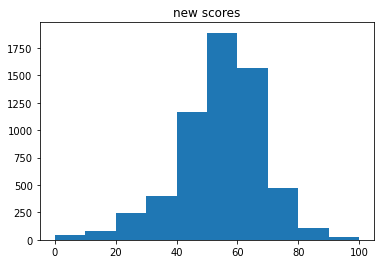

In [38]:
# Distribution of scores with new scheme assigned by us
plt.hist(y)
plt.title('new scores')
plt.show()

In [39]:
X = funds.loc[esg_funds.index]
X['Average Market Cap (Mil)'] = X['Average Market Cap (Mil)'].apply(lambda x: x.replace(',', '')).astype('float')
X['Fund Size (Mil)'] = X['Fund Size (Mil)'].apply(lambda x: x.replace(',', '')).astype('float')

In [40]:
X = X.iloc[:, [3, 10, 11, 12, 13,14,15,16,17,18,19,23,24,25]]

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5993 entries, 0 to 6002
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Yield (%)                                           5906 non-null   float64
 1   Sustainable Investment - ESG Fund                   5993 non-null   object 
 2   Sustainable Investment - Impact Fund                5993 non-null   object 
 3   Sustainable Investment - Environmental Sector Fund  5987 non-null   object 
 4   Animal Testing                                      5993 non-null   int64  
 5   % Alcohol                                           5993 non-null   float64
 6   % Fossil Fuels                                      5993 non-null   float64
 7   % Small Arms                                        5993 non-null   float64
 8   % Thermal Coal                                      5993 non-null   float64
 9

In [42]:
null_cols = X[X['10 Years Annualized (%)'].isna()]
null_cols

,Yield (%),Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund,Animal Testing,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,YTD Return (%),10 Years Annualized (%),Fund Size (Mil),Average Market Cap (Mil)
3117,1.01,No,No,No,0,1.09,7.17,0.89,0.96,0.72,15.97,NaN,422.79,59549.90
3118,0.98,No,No,No,0,1.09,7.17,0.89,0.96,0.72,16.15,NaN,422.79,59549.90
3119,0.90,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.59,NaN,1541.14,64947.76
3120,0.67,No,No,No,0,1.03,6.94,0.66,1.09,0.74,12.87,NaN,1541.14,64947.76
3121,0.98,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.90,NaN,1541.14,64947.76
3122,0.92,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.35,NaN,1541.14,64947.76
3123,1.01,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.97,NaN,1541.14,64947.76
3124,1.11,No,No,No,0,1.03,6.94,0.66,1.09,0.74,14.01,NaN,1541.14,64947.76
3125,0.92,No,No,No,0,1.05,7.32,0.74,1.08,0.72,15.67,NaN,1370.68,65318.97
3126,0.62,No,No,No,0,1.05,7.32,0.74,1.08,0.72,14.97,NaN,1370.68,65318.97


In [43]:
funds.loc[null_cols.index]

,Name,Ticker,Morningstar Sustainability Rating,Yield (%),Morningstar Category,Portfolio Sustainability Score,Portfolio Environmental Score,Portfolio Social Score,Portfolio Governance Score,Sustainable Investment by Prospectus,Sustainable Investment - ESG Fund,Sustainable Investment - Impact Fund,Sustainable Investment - Environmental Sector Fund,Animal Testing,% Alcohol,% Fossil Fuels,% Small Arms,% Thermal Coal,% Tobacco,YTD Return (%),1 Year Annualized (%),3 Years Annualized (%),5 Years Annualized (%),10 Years Annualized (%),Fund Size (Mil),Average Market Cap (Mil),Average Credit Quality
3117,Fidelity Advisor Freedom�������������,FIJTX,3.0,1.01,Target Date,22.93,3.99,8.99,7.15,No,No,No,No,0,1.09,7.17,0.89,0.96,0.72,15.97,36.37,17.79,14.78,NaN,422.79,59549.9,BB
3118,Fidelity Advisor Freedom��������������,FNGLX,3.0,0.98,Target Date,22.93,3.99,8.99,7.15,No,No,No,No,0,1.09,7.17,0.89,0.96,0.72,16.15,36.54,17.96,14.94,NaN,422.79,59549.9,BB
3119,Fidelity Advisor Freedom������������������,FHJGX,3.0,0.90,Target Date,22.81,4.06,9.25,7.28,No,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.59,31.85,16.37,14.94,NaN,1541.14,64947.76,BBB
3120,Fidelity Advisor Freedom������������������,FHVCX,3.0,0.67,Target Date,22.81,4.06,9.25,7.28,No,No,No,No,0,1.03,6.94,0.66,1.09,0.74,12.87,30.91,15.49,14.94,NaN,1541.14,64947.76,BBB
3121,Fidelity Advisor Freedom������������������,FHGDX,3.0,0.98,Target Date,22.81,4.06,9.25,7.28,No,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.90,32.19,16.70,14.94,NaN,1541.14,64947.76,BBB
3122,Fidelity Advisor Freedom������������������,FHBCX,3.0,0.92,Target Date,22.81,4.06,9.25,7.28,No,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.35,31.52,16.06,14.94,NaN,1541.14,64947.76,BBB
3123,Fidelity Advisor Freedom������������������,FHSDX,3.0,1.01,Target Date,22.81,4.06,9.25,7.28,No,No,No,No,0,1.03,6.94,0.66,1.09,0.74,13.97,32.40,16.78,14.94,NaN,1541.14,64947.76,BBB
3124,Fidelity Advisor Freedom������������������ B,FHQCX,3.0,1.11,Target Date,22.81,4.06,9.25,7.28,No,No,No,No,0,1.03,6.94,0.66,1.09,0.74,14.01,32.48,16.90,14.94,NaN,1541.14,64947.76,BBB
3125,Fidelity Advisor Freedom������������������,FHDEX,3.0,0.92,Target Date,22.73,4.12,9.14,7.28,No,No,No,No,0,1.05,7.32,0.74,1.08,0.72,15.67,36.28,17.54,14.94,NaN,1370.68,65318.97,BB
3126,Fidelity Advisor Freedom������������������,FHZEX,3.0,0.62,Target Date,22.73,4.12,9.14,7.28,No,No,No,No,0,1.05,7.32,0.74,1.08,0.72,14.97,35.12,16.64,14.94,NaN,1370.68,65318.97,BB


In [44]:
# find funds named with Fidelity Advisor Freedom to fill the null values
temp = funds[funds['Name'].str.contains('Fidelity Advisor Freedom')==True]
temp[['1 Year Annualized (%)', '3 Years Annualized (%)', '5 Years Annualized (%)','10 Years Annualized (%)']]


,1 Year Annualized (%),3 Years Annualized (%),5 Years Annualized (%),10 Years Annualized (%)
3091,35.84,17.38,14.42,11.24
3092,34.90,16.52,13.58,10.41
3093,36.18,17.67,14.70,11.51
3094,35.52,17.10,14.14,10.96
3095,36.37,17.80,14.77,11.55
...,...,...,...,...
3150,35.20,16.59,14.94,NaN
3151,36.58,17.76,14.94,NaN
3152,35.85,17.19,14.94,NaN
3153,36.62,17.88,14.94,NaN


In [45]:
# fill with the mean of the values in the rest of the dataframe above
X['10 Years Annualized (%)'].fillna(temp['10 Years Annualized (%)'].mean(),inplace=True)

In [46]:
X['Sustainable Investment - Environmental Sector Fund'].value_counts()

No     5952
Yes      35
Name: Sustainable Investment - Environmental Sector Fund, dtype: int64

In [47]:
X['Sustainable Investment - Environmental Sector Fund'].replace({'Yes':1, 'No':0}, inplace=True)

In [48]:
X['Sustainable Investment - Environmental Sector Fund'].fillna(0, inplace=True)

In [49]:
X['Sustainable Investment - ESG Fund'].replace({'Yes':1, 'No':0}, inplace=True)
X['Sustainable Investment - Impact Fund'].replace({'Yes':1, 'No':0}, inplace=True)

In [50]:
X['Sustainable Investment - Environmental Sector Fund'] = X['Sustainable Investment - Environmental Sector Fund'].astype(int)

In [51]:
X['Yield (%)'].fillna(X['Yield (%)'].median(), inplace=True)

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5993 entries, 0 to 6002
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Yield (%)                                           5993 non-null   float64
 1   Sustainable Investment - ESG Fund                   5993 non-null   int64  
 2   Sustainable Investment - Impact Fund                5993 non-null   int64  
 3   Sustainable Investment - Environmental Sector Fund  5993 non-null   int64  
 4   Animal Testing                                      5993 non-null   int64  
 5   % Alcohol                                           5993 non-null   float64
 6   % Fossil Fuels                                      5993 non-null   float64
 7   % Small Arms                                        5993 non-null   float64
 8   % Thermal Coal                                      5993 non-null   float64
 9

In [53]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
rfr = RandomForestRegressor(random_state=42)
param_grid = {'bootstrap': [True],
 'max_depth': [10, 30, 50],
 'n_estimators': [200, 400, 600]}
CV = RandomizedSearchCV(estimator = rfr, param_distributions = param_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
CV.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 30, 50],
                                        'n_estimators': [200, 400, 600]},
                   random_state=42, verbose=2)

In [55]:
print('best model:', CV.best_params_,'\nbest score: %.2f' % CV.best_score_)

best model: {'n_estimators': 600, 'max_depth': 30, 'bootstrap': True} 
best score: 0.88


In [56]:
best_rfr=RandomForestRegressor(random_state=42, n_estimators=600, max_depth=30, bootstrap='True')
best_rfr.fit(x_train,y_train)
print('train accuracy: %.2f' % best_rfr.score(x_train,y_train))

train accuracy: 0.99


In [57]:
# Accuracy score of model
print('test accuracy: %.2f' % best_rfr.score(x_test,y_test))

test accuracy: 0.91


In [58]:
# Importance values of each variable constructing the model
["%.5f"%item for item in best_rfr.feature_importances_]

['0.03468',
 '0.01161',
 '0.00517',
 '0.00030',
 '0.00088',
 '0.02719',
 '0.07289',
 '0.03395',
 '0.03737',
 '0.02079',
 '0.10931',
 '0.14205',
 '0.06753',
 '0.43628']

<BarContainer object of 14 artists>

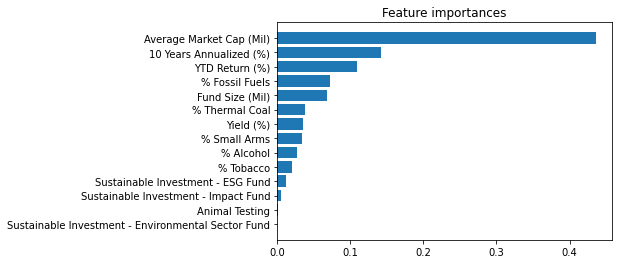

In [59]:
fig, ax = plt.subplots()
ax.set_title("Feature importances")
# plt.barh(X.columns.values, best_rfr.feature_importances_)
sorted = best_rfr.feature_importances_.argsort()
plt.barh(X.columns[sorted], best_rfr.feature_importances_[sorted])

In [60]:
# Input a fund's data and predict the score
fund_exp = [3.88,1,1,1,1,0,0,0,0,1,11.98,12.57,200.59,35000.37]
fund_exp_standard = np.array(fund_exp).reshape(1,-1)
outcome = best_rfr.predict(fund_exp_standard)
print("The predicted score for this fund is ", outcome)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


The predicted score for this fund is  [50.31870421]


In [61]:
# Remove variables with low importance values
X_new = X.iloc[:, sorted[7:]]
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5993 entries, 0 to 6002
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Yield (%)                 5993 non-null   float64
 1   % Thermal Coal            5993 non-null   float64
 2   Fund Size (Mil)           5993 non-null   float64
 3   % Fossil Fuels            5993 non-null   float64
 4   YTD Return (%)            5993 non-null   float64
 5   10 Years Annualized (%)   5993 non-null   float64
 6   Average Market Cap (Mil)  5993 non-null   float64
dtypes: float64(7)
memory usage: 374.6 KB


In [62]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=0.2, random_state=42)
best_rfr.fit(x_train_new,y_train_new)
print('train accuracy: %.2f' % best_rfr.score(x_train_new,y_train_new))

train accuracy: 0.99


In [63]:
print('test accuracy: %.2f' % best_rfr.score(x_test_new,y_test_new))

test accuracy: 0.90


In [64]:
# Repredict the same example but removing unimportant variables
fund_exp = [3.88,0,200.59,0,11.98,12.57,35000.37]
fund_exp_standard = np.array(fund_exp).reshape(1,-1)
outcome = best_rfr.predict(fund_exp_standard)
print("The predicted score for this fund is ", outcome)

The predicted score for this fund is  [49.26628181]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


##Visualization (Dashboard)

In [65]:
pandas_bokeh.output_notebook()

In [66]:
import math
funds['new_score']=y 
sample = funds.sample(math.floor(0.01*funds.shape[0]))

In [67]:
# funds.pivot(columns='Average Credit Quality')['Portfolio Sustainability Score'].plot_bokeh(kind='point')
p_scatter_score_return = sample.plot_bokeh.scatter(x='10 Years Annualized (%)', y='new_score',show_figure = False ,color ='#4292c6',fill_alpha=1)
p_scatter_environment_score = sample.plot_bokeh.scatter(x='new_score', y = 'Portfolio Environmental Score', show_figure = False, color ='#4292c6',fill_alpha=1)
p_scatter_social_score = sample.plot_bokeh.scatter(x='new_score', y = 'Portfolio Social Score', show_figure = False, color ='#4292c6',fill_alpha=1)
p_score_count = y.plot_bokeh(kind="hist",show_figure = False , color ='#4292c6',fill_alpha=1)

In [68]:
# histogram 
# since we will need the sustaniability rating, I impert the data again
# pandas_bokeh.output_notebook()
funds=pd.read_csv('/content/drive/Shareddrives/RMDS/funds.csv')
sus_and_return_df = funds[['Morningstar Sustainability Rating','10 Years Annualized (%)']].dropna()
mean_by_sus = sus_and_return_df.groupby('Morningstar Sustainability Rating', as_index=False)['10 Years Annualized (%)'].mean()
rating_count = funds.groupby(['Morningstar Sustainability Rating']).size()
p_bar_rating_return =mean_by_sus.groupby(['Morningstar Sustainability Rating']).mean().plot_bokeh(kind="barh",show_figure=False,color ='#4292c6',fill_alpha=1)
p_bar_rating_count = rating_count.groupby(['Morningstar Sustainability Rating']).mean().plot_bokeh(kind="bar",show_figure=False, color ='#4292c6',fill_alpha=1,ylabel='count')


pandas_bokeh.plot_grid([[p_bar_rating_count,p_bar_rating_return,p_scatter_environment_score],[p_score_count,p_scatter_score_return,p_scatter_social_score]], plot_width=350)
#rating_count

Column(id='1464', ...)